In [109]:
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.datasets import make_regression
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [110]:
% matplotlib inline

In [111]:
class Gaussian_Process():
    
    def __init__(self, kernel):
        self.kernel = kernel
        self.gp_ = GaussianProcessRegressor(kernel=kernel,
                                            optimizer = None,
                                            normalize_y = True)
    
    def optimise_with_splice_sampling(self, initial_rho, num_iters, sigma, burn_in,  X, y):
        self.fit(X, y)
        slice_sampler = Slice_sampler(num_iters = num_iters, 
                                      sigma = sigma, 
                                      burn_in = burn_in,
                                      gp = self)
        samples = slice_sampler.sample(init = initial_rho)
        
        rho_opt = [np.mean(samples_k) for samples_k in samples]
        
        theta_opt = theta = np.log(1+np.exp(rho_opt))
        
        # kernel__k1__noise_level = noise of the data
        # kernel__k2__k1__constant_value = aplitude
        # kernel__k2__k2__length_scale = Matern length scales
        
        self.gp_.set_params(**{"kernel__k1__noise_level": np.abs(theta_opt[0]),
                              "kernel__k2__k1__constant_value": np.abs(theta_opt[1]),
                              "kernel__k2__k2__length_scale": theta_opt[2:]})
        
    def log_marginal_likelihood(self,rho):
        theta = np.log(1+np.exp(rho))
        theta = [theta[0],theta[1],theta[2:]]
        return self.gp_.log_marginal_likelihood(theta)
    
    def log_prior_parameters(self, rho):
        return np.sum(np.log([ss.norm(0, 1).pdf(rho_k) for rho_k in rho]))
    
    def log_joint_unnorm(self, rho):
        return self.log_marginal_likelihood(rho) + self.log_prior_parameters(rho)
        
    def fit(self, X, y):
        self.gp_.fit(X, y)
    
    def predict(self, X):
        mu, sigma = self.gp_.predict(X, return_std=True)
        return mu, sigma
    
    def get_params(self):
        return self.gp_.get_params()

In [112]:
class Slice_sampler():
    
    def __init__(self, num_iters, sigma, burn_in, gp):
        self.num_iters = num_iters
        self.sigma = sigma
        self.burn_in = burn_in
        self.gp = gp
        
    def sample(self, init, step_out=True):

        D = len(init)
        samples = np.zeros((D, self.num_iters))
        
        xx = init.copy()

        for i in xrange(self.num_iters + self.burn_in):
            perm = range(D)
            np.random.shuffle(perm)
            last_llh = self.gp.log_joint_unnorm(xx)

            for d in perm:
                llh0 = last_llh + np.log(np.random.rand())
                rr = np.random.rand(1)
                x_l = xx.copy()
                x_l[d] = x_l[d] - rr * self.sigma[d]
                x_r = xx.copy()
                x_r[d] = x_r[d] + (1 - rr) * self.sigma[d]

                if step_out:
                    llh_l = self.gp.log_joint_unnorm(x_l)
                    while llh_l > llh0:
                        x_l[d] = x_l[d] - self.sigma[d]
                        llh_l = self.gp.log_joint_unnorm(x_l)
                    llh_r = self.gp.log_joint_unnorm(x_r)
                    while llh_r > llh0:
                        x_r[d] = x_r[d] + self.sigma[d]
                        llh_r = self.gp.log_joint_unnorm(x_r)

                x_cur = xx.copy()
                while True:
                    xd = np.array(np.random.rand() * (x_r[d] - x_l[d]) + x_l[d])
                    x_cur[d] = xd.copy()
                    last_llh = self.gp.log_joint_unnorm(x_cur)
                    if last_llh > llh0:
                        xx[d] = xd.copy()
                        break
                    elif xd > xx[d]:
                        x_r[d] = xd
                    elif xd < xx[d]:
                        x_l[d] = xd
                    else:
                        raise RuntimeError('Slice sampler shrank too far.')
                
            if i == 0:
                print "burn-in"
            elif i > self.burn_in and i % 100 == 0: 
                print 'iteration', i - self.burn_in
            
            if i > self.burn_in:   
                samples[:, i-self.burn_in] = xx.copy().ravel()
        
        plt.hist(samples[0])
        plt.hist(samples[1])
        plt.hist(samples[2])

        return samples

In [113]:
#X, y = make_regression(n_features = 3)

In [114]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

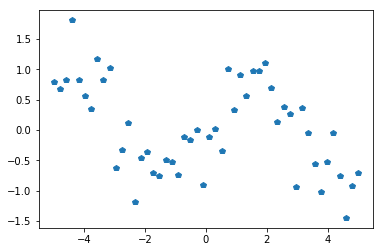

In [115]:
X_train = np.linspace(-5,5,50)
y_train = np.sin(X_train) + np.random.normal(loc = 0, scale = 0.5,size=50)
plt.plot(X_train, y_train, "p")

In [116]:
X_train = X_train.reshape([-1,1])

In [117]:
kernel = kernels.Sum(kernels.WhiteKernel(),kernels.Product(kernels.ConstantKernel(),kernels.Matern(nu=5./2.)))
gp = Gaussian_Process(kernel = kernel)

burn-in
iteration 90
iteration 190


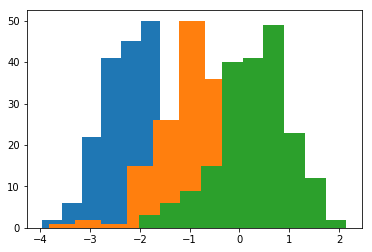

In [118]:
gp.optimise_with_splice_sampling(initial_rho = np.array([1.,1.,1.]),
                                 num_iters = 200,
                                 sigma = np.array([1.,1.,1.]),
                                 burn_in = 10,
                                 X = X_train,
                                 y = y_train)

In [119]:
gp.get_params()

{'alpha': 1e-10,
 'copy_X_train': True,
 'kernel': WhiteKernel(noise_level=0.111) + 0.682**2 * Matern(length_scale=0.844, nu=2.5),
 'kernel__k1': WhiteKernel(noise_level=0.111),
 'kernel__k1__noise_level': 0.11125754920707707,
 'kernel__k1__noise_level_bounds': (1e-05, 100000.0),
 'kernel__k2': 0.682**2 * Matern(length_scale=0.844, nu=2.5),
 'kernel__k2__k1': 0.682**2,
 'kernel__k2__k1__constant_value': 0.46491074835045793,
 'kernel__k2__k1__constant_value_bounds': (1e-05, 100000.0),
 'kernel__k2__k2': Matern(length_scale=0.844, nu=2.5),
 'kernel__k2__k2__length_scale': array([ 0.84377329]),
 'kernel__k2__k2__length_scale_bounds': (1e-05, 100000.0),
 'kernel__k2__k2__nu': 2.5,
 'n_restarts_optimizer': 0,
 'normalize_y': True,
 'optimizer': None,
 'random_state': None}

In [120]:
gp.fit(X_train, y_train)

In [121]:
X_test = np.linspace(-7,7,50).reshape([-1,1])

In [122]:
mu, sigma = gp.predict(X_test)

In [123]:
#r2_score(y_true = y_test, y_pred = mu)

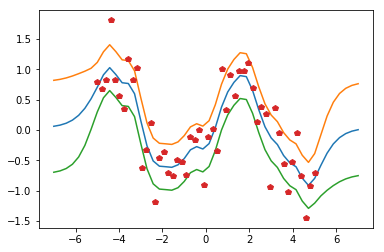

In [124]:
plt.plot(X_test, mu)
plt.plot(X_test, mu+sigma)
plt.plot(X_test, mu-sigma)
plt.plot(X_train, y_train, "p")